In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tfdirectional as tfdir
import tensorflow as tf

In [3]:
rotation = tf.placeholder(shape=(32,3,3), dtype=tf.float32)
concentration = tf.placeholder(shape=(32,3), dtype=tf.float32)

vec = tf.placeholder(shape=(32,3), dtype=tf.float32)

distr = tfdir.distributions.Bingham(rotation, concentration)

In [4]:
l = distr.log_prob(vec)

In [5]:
sess = tf.Session()

In [6]:
sess.run(l, feed_dict={rotation: randn(32,3,3),
                       concentration: randn(32,3),
                        vec: randn(32,3)})

array([ -23.536997 ,   -5.739885 ,   -3.425581 ,   -4.6847277,
          6.602025 ,  -72.55493  , -104.2939   ,   -9.636457 ,
         -7.1953807,  -10.437334 ,  -20.934624 ,   -8.899902 ,
        -56.835766 ,  -18.36535  ,   -5.73306  ,   11.668604 ,
        -11.479417 ,    5.9095106,   -2.3971958,    4.5957913,
        -13.589838 ,  -10.556042 ,  -23.021978 ,   -9.379677 ,
        -68.48471  ,  -16.447325 ,  -26.940208 ,  -35.95615  ,
        -30.62872  ,  -67.39016  ,  -53.664917 ,  -33.078552 ],
      dtype=float32)

In [34]:
s = 64
batch_size=s**2

# sample polar coordimnates
theta = np.linspace(0, np.pi, s)
phi = np.linspace(0, 2*np.pi, s)
phi, theta = np.meshgrid(phi, theta)

# cartesian coordinates of the unit sphere
r = 1.0
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

v = np.stack([x,y,z],axis=-1)

In [35]:
# Build orientation matrix
def rotation_matrix(angle, direction, point=None):
    """Return matrix to rotate about axis defined by point and direction.

    >>> R = rotation_matrix(math.pi/2, [0, 0, 1], [1, 0, 0])
    >>> numpy.allclose(numpy.dot(R, [0, 0, 0, 1]), [1, -1, 0, 1])
    True
    >>> angle = (random.random() - 0.5) * (2*math.pi)
    >>> direc = numpy.random.random(3) - 0.5
    >>> point = numpy.random.random(3) - 0.5
    >>> R0 = rotation_matrix(angle, direc, point)
    >>> R1 = rotation_matrix(angle-2*math.pi, direc, point)
    >>> is_same_transform(R0, R1)
    True
    >>> R0 = rotation_matrix(angle, direc, point)
    >>> R1 = rotation_matrix(-angle, -direc, point)
    >>> is_same_transform(R0, R1)
    True
    >>> I = numpy.identity(4, numpy.float64)
    >>> numpy.allclose(I, rotation_matrix(math.pi*2, direc))
    True
    >>> numpy.allclose(2, numpy.trace(rotation_matrix(math.pi/2,
    ...                                               direc, point)))
    True

    """
    sina = math.sin(angle)
    cosa = math.cos(angle)
    direction = unit_vector(direction[:3])
    # rotation matrix around unit vector
    R = numpy.diag([cosa, cosa, cosa])
    R += numpy.outer(direction, direction) * (1.0 - cosa)
    direction *= sina
    R += numpy.array([[ 0.0,         -direction[2],  direction[1]],
                      [ direction[2], 0.0,          -direction[0]],
                      [-direction[1], direction[0],  0.0]])
    M = numpy.identity(4)
    M[:3, :3] = R
    if point is not None:
        # rotation not around origin
        point = numpy.array(point[:3], dtype=numpy.float64, copy=False)
        M[:3, 3] = point - numpy.dot(R, point)
    return M

def unit_vector(data, axis=None, out=None):
    """Return ndarray normalized by length, i.e. Euclidean norm, along axis.

    >>> v0 = numpy.random.random(3)
    >>> v1 = unit_vector(v0)
    >>> numpy.allclose(v1, v0 / numpy.linalg.norm(v0))
    True
    >>> v0 = numpy.random.rand(5, 4, 3)
    >>> v1 = unit_vector(v0, axis=-1)
    >>> v2 = v0 / numpy.expand_dims(numpy.sqrt(numpy.sum(v0*v0, axis=2)), 2)
    >>> numpy.allclose(v1, v2)
    True
    >>> v1 = unit_vector(v0, axis=1)
    >>> v2 = v0 / numpy.expand_dims(numpy.sqrt(numpy.sum(v0*v0, axis=1)), 1)
    >>> numpy.allclose(v1, v2)
    True
    >>> v1 = numpy.empty((5, 4, 3))
    >>> unit_vector(v0, axis=1, out=v1)
    >>> numpy.allclose(v1, v2)
    True
    >>> list(unit_vector([]))
    []
    >>> list(unit_vector([1]))
    [1.0]

    """
    if out is None:
        data = numpy.array(data, dtype=numpy.float64, copy=True)
        if data.ndim == 1:
            data /= math.sqrt(numpy.dot(data, data))
            return data
    else:
        if out is not data:
            out[:] = numpy.array(data, copy=False)
        data = out
    length = numpy.atleast_1d(numpy.sum(data*data, axis))
    numpy.sqrt(length, length)
    if axis is not None:
        length = numpy.expand_dims(length, axis)
    data /= length
    if out is None:
        return data

In [36]:
r = rotation_matrix(pi/2, [1, 0, 0])
r = repeat(r[:3,:3].reshape((1,3,3)),batch_size,axis=0).astype('float32')

c = repeat(array([0.3,0.5,0]).reshape((1,3)),batch_size,axis=0).astype('float32')

In [37]:
vec = tf.placeholder(shape=(batch_size,3), dtype=tf.float32)
distr = tfdir.distributions.Bingham(r,15*c)
          
l = distr.log_prob(vec)
pdf = exp(sess.run(l, feed_dict={vec: v.reshape((-1,3))}))
pdf = pdf/pdf.max()

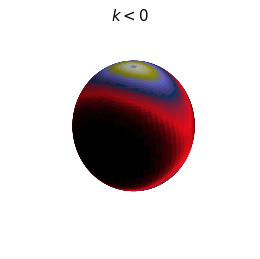

In [38]:
# set up a figure
fig = plt.figure(figsize=(15.0,4.5))

# calculate the pdf for given k<0
fcolors = pdf.reshape((s,s))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_title(r'$k<0$', fontsize=15)
ax.plot_surface(x, y, z,  rstride=1, cstride=1,
                facecolors=cm.gist_stern(fcolors))
ax.set_axis_off()

## Implementation of Orthogonal matrices with Householder reflections

In [39]:
# Implementation in 3D
H1 = eye(3)
H2 = eye(3)
H3 = eye(3)

u1 = 1
u2 = randn(2).reshape([2,1])
u3 = randn(3).reshape([3,1])

H2[1:,1:] = H2[1:,1:] - 2.* u2.dot(u2.T)/norm(u2)**2
H3[0:,0:] = H3[0:,0:] - 2.* u3.dot(u3.T)/norm(u3)**2

W = H1.dot(H2.dot(H3))
r = W

In [40]:
r = repeat(r[:3,:3].reshape((1,3,3)),batch_size,axis=0).astype('float32')

In [60]:
c = repeat(array([2.,0.25,0]).reshape((1,3)),batch_size,axis=0).astype('float32')

In [61]:
vec = tf.placeholder(shape=(batch_size,3), dtype=tf.float32)
distr = tfdir.distributions.Bingham(r,-20.*c)
          
l = distr.log_prob(vec)
pdf = exp(sess.run(l, feed_dict={vec: v.reshape((-1,3))}))
pdf = pdf/pdf.max()

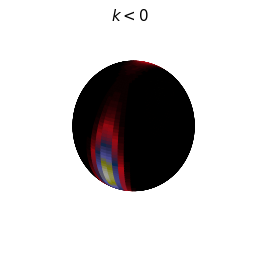

In [62]:
# set up a figure
fig = plt.figure(figsize=(15.0,4.5))

# calculate the pdf for given k<0
fcolors = pdf.reshape((s,s))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_title(r'$k<0$', fontsize=15)
ax.plot_surface(x, y, z,  rstride=1, cstride=1,
                facecolors=cm.gist_stern(fcolors))
ax.set_axis_off()

## Implementation of algorithm for sampling from Bingham

In [71]:
samp = np.concatenate([sess.run(distr.sample()) for i in range(10) ]);

/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead',

/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead',

/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead',

/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead',

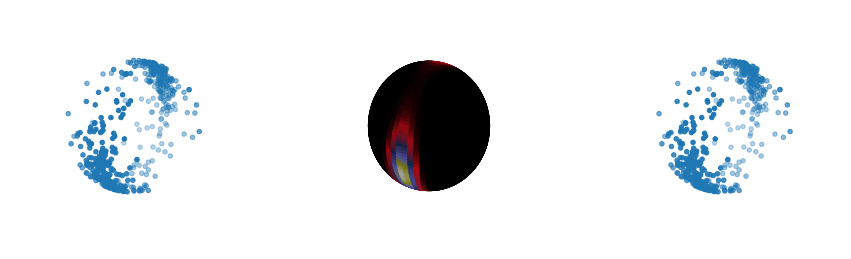

In [72]:
fig = plt.figure(figsize=(15.0,4.5))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(samp[:500,0], samp[:500,1], samp[:500,2])

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_axis_off()

ax = fig.add_subplot(132, projection='3d')

ax.plot_surface(x, y, z,  rstride=1, cstride=1,
                facecolors=cm.gist_stern(fcolors))
ax.set_axis_off()


ax = fig.add_subplot(133, projection='3d')
ax.scatter(samp[:500,0], samp[:500,1], samp[:500,2])

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_axis_off()

In [73]:
from physt import histogram, binnings, special

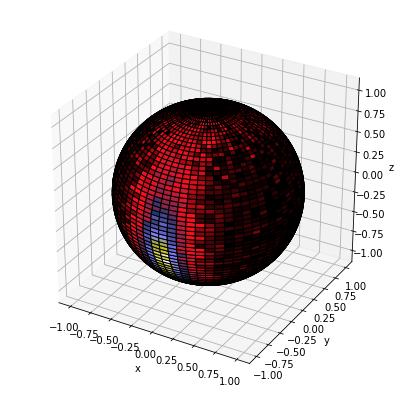

In [74]:
directions = samp
h = special.spherical_histogram(directions, radial_bins=1, theta_bins=64, phi_bins=64, )
h.projection("theta", "phi").plot.globe_map(density=True, figsize=(7, 7), cmap="gist_stern")

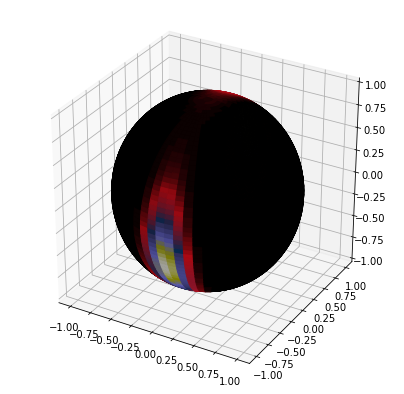

In [70]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1,
                facecolors=cm.gist_stern(fcolors))